In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import seaborn as sns
import swifter
import json
from collections import namedtuple
import re
import copy

import itertools
from pprint import pprint

# Functions

In [2]:
# Find files
# This function input the path of experiment directory and output a list of device directories of the experiment directory.
def find_device_under_exp(exp_dir_path):
    dev_dir_list = sorted([os.path.join(exp_dir_path, d) for d in os.listdir(exp_dir_path) if d.startswith('qc') or d.startswith('sm')])
    return dev_dir_list

def find_trace_under_device(dev_dir_path):
    trace_dir_list = sorted([os.path.join(dev_dir_path, d) for d in os.listdir(dev_dir_path)])
    return trace_dir_list


# Convenience instance
class EXPERIMENT():
    def __init__(self, exp_dir_path, settings):
        self.path = exp_dir_path
        self.settings = json.loads(settings)
    def __repr__(self):
        return f'EXP: {self.path} -> {self.settings}'

In [3]:
def parse_mi_ho(f):

    df = pd.read_csv(f)
    df["Timestamp"] = df["Timestamp"].swifter.apply(lambda x: pd.to_datetime(x) + dt.timedelta(hours=8)) 
    nr_pci = 'O'
    scells = []

    def NR_OTA(idx):

        if df["type_id"].iloc[idx] == "5G_NR_RRC_OTA_Packet": return True
        else: return False
    
    def LTE_SERV_INFO(idx):

        if df["type_id"].iloc[idx] == "LTE_RRC_Serv_Cell_Info": return True
        else: return False
    

    def find_1st_after(start_idx, target, look_after=1):
        for j in range(start_idx, len(df)):
            t_ = df["Timestamp"].iloc[j]
            if NR_OTA(j) or LTE_SERV_INFO(j):
                continue
            if (t_ - t).total_seconds() > look_after:
                return None, None
            if df[target].iloc[j] not in [0,'0'] and not np.isnan(df[target].iloc[j]):
                return t_, j
        return None, None
    
    def find_1st_before(start_idx, target, look_before=1):
        for j in range(start_idx, -1, -1):
            t_ = df["Timestamp"].iloc[j]
            if NR_OTA(j) or LTE_SERV_INFO(j):
                continue
            if (t - t_).total_seconds() > look_before:
                return None, None
            if df[target].iloc[j] not in [0,'0'] and not np.isnan(df[target].iloc[j]):
                return t_, j
        return None, None
    
    def find_1st_before_with_special_value(start_idx, target, target_value, look_before=1):
        for j in range(start_idx, -1, -1):
            t_ = df["Timestamp"].iloc[j]
            if NR_OTA(j) or LTE_SERV_INFO(j):
                continue
            if (t - t_).total_seconds() > look_before:
                return None, None
            if df[target].iloc[j] in [target_value] and not np.isnan(df[target].iloc[j]):
                return t_, j
        return None, None
    
    def find_in_D_exact(targets):

        l = []
        # In l : (second, ho_type)
        for target in targets:
            for ho in D[target]:
                l.append(((t - ho.start).total_seconds(), target))

        if len(l) != 0:
            for x in l:
                if (x[0]== 0):
                    return x[1]
        
        return None
    
    def find_in_D_first_before(targets, look_before=1):

        l = []
        # In l : (second, ho_type)
        for target in targets:
            for ho in D[target]:
                l.append(((t - ho.end).total_seconds(), target, ho))

        if len(l) != 0:
            closest = min(filter(lambda x: x[0] > 0, l), key=lambda x: x[0])
            if 0 <= closest[0] < look_before:
                return closest[1], closest[2]
        
        return None, None

    HO = namedtuple('HO',['start', 'end', 'others', 'trans'], defaults=[None,None,'',''])
    
    D = {
        'Conn_Rel':[], 
        'Conn_Req':[], # Setup
        'LTE_HO': [], # LTE -> newLTE
        'MN_HO': [], # LTE + NR -> newLTE + NR
        'MN_HO_to_eNB': [], # LTE + NR -> newLTE
        'SN_setup': [], # LTE -> LTE + NR => NR setup
        'SN_Rel': [], # LTE + NR -> LTE
        'SN_HO': [], # LTE + NR -> LTE + newNR  
        'RLF_II': [],
        'RLF_III': [],
        'SCG_RLF': [],
        'Add_SCell': [],
        }
    
    for i in range(len(df)):

        # Pass NR RRC packet. In NSA mode, LTE RRC packet include NR packet message.
        if NR_OTA(i) or LTE_SERV_INFO(i):
            continue

        try: lte_pci, lte_earfcn
        except: 
            lte_pci = df["PCI"].iloc[i]
            lte_earfcn = int(df["Freq"].iloc[i])

        others = ''
        t = df["Timestamp"].iloc[i]

        if df["rrcConnectionRelease"].iloc[i] == 1:
            D['Conn_Rel'].append(HO(start=t))
            nr_pci = 'O'

        if df["rrcConnectionRequest"].iloc[i] == 1:
            
            # Define end of rrcConnectionRequest to be rrcConnectionReconfigurationComplete or securityModeComplete.
            a = find_1st_after(i, 'rrcConnectionReconfigurationComplete',look_after=2)[0]
            b = find_1st_after(i, 'securityModeComplete',look_after=2)[0]
        
            if a is None and b is None: end = None
            elif a is None and b is not None: end = b
            elif a is not None and b is None: end = a 
            else: end = a if a > b else b
            
            _, idx = find_1st_after(i, 'ueCapabilityInformation',look_after=1)
            if idx is not None:
                sup_band = df['bandEUTRA'].iloc[idx]
                others += f' supported band: {sup_band}.' 

            serv_cell, serv_freq = df["PCI"].iloc[i], int(df["Freq"].iloc[i])
            trans = f'({lte_pci}, {lte_earfcn}) -> ({serv_cell}, {serv_freq})'
            
            # Check if caused by RLF III.
            a, idx = find_1st_before(i, 'rrcConnectionReestablishmentReject', look_before=1)
            if a is not None:
                others += ' After RLF III.'

            D['Conn_Req'].append(HO(start=t,end=end,trans=trans, others=others))

            nr_pci = 'O'
            lte_pci = serv_cell
            lte_earfcn = serv_freq
            
        if df["lte-rrc.t304"].iloc[i] == 1:
            
            end, _ = find_1st_after(i, 'rrcConnectionReconfigurationComplete')
            serv_cell, target_cell = df["PCI"].iloc[i], int(df['lte_targetPhysCellId'].iloc[i])
            serv_freq, target_freq = int(df["Freq"].iloc[i]), int(df['dl-CarrierFreq'].iloc[i])

            lte_pci = target_cell
            lte_earfcn = target_freq

            if df["SCellToAddMod-r10"].iloc[i] == 1:
                n =len(str(df["SCellIndex-r10.1"].iloc[i]).split('@'))
                others += f' Set up {n} SCell.'
            else:
                scells = []
            
            if serv_freq != target_freq:
                a,b = find_1st_before(i, "rrcConnectionReestablishmentRequest", 1)
                others += " Inter frequency HO."
                if a is not None:
                    others += " Near after RLF."
                
            if df["nr-rrc.t304"].iloc[i] == 1 and df["dualConnectivityPHR: setup (1)"].iloc[i] == 1:
                
                if serv_cell == target_cell and serv_freq == target_freq:

                    a, _ = find_1st_before(i, "rrcConnectionReestablishmentRequest", 2)
                    
                    if a is not None:

                        ho_type, ho = find_in_D_first_before(['RLF_II', 'RLF_III'], 2)
                        others += f' Near after RLF of trans: {ho.trans}.'

                    else:
                        
                        ho_type, _ = find_in_D_first_before(['MN_HO_to_eNB', 'SN_Rel'], 2)
                        if ho_type is not None:
                            others += f' Near after {ho_type}.'

                    ori_serv = nr_pci
                    nr_pci = int(df['nr_physCellId'].iloc[i])
                    trans = f'({serv_cell}, {serv_freq}) | {ori_serv} -> {nr_pci}'
                    D['SN_setup'].append(HO(start=t, end=end, others=others, trans=trans))

                else:
                    
                    nr_pci = int(df['nr_physCellId'].iloc[i])
                    trans = f'({serv_cell}, {serv_freq}) -> ({target_cell}, {target_freq}) | {nr_pci}'
                    D['MN_HO'].append(HO(start=t, end=end, others=others, trans=trans))

            else:
                
                if serv_cell == target_cell and serv_freq == target_freq:

                    a, b = find_1st_before(i, "scgFailureInformationNR-r15")
                    if a is not None:
                        others += " Caused by scg-failure."
                    
                    orig_serv = nr_pci
                    nr_pci = 'O'
                    trans = f'({serv_cell}, {serv_freq}) | {orig_serv} -> {nr_pci}'
                    D['SN_Rel'].append(HO(start=t, end=end, others=others, trans=trans))
                    
                else:

                    a, _ = find_1st_before(i,"rrcConnectionSetup",3)
                    if a is not None:
                        others += ' Near After connection setup.'
                    if nr_pci == 'O':
                        trans = f'({serv_cell}, {serv_freq}) -> ({target_cell}, {target_freq}) | {nr_pci}'
                        D['LTE_HO'].append(HO(start=t, end=end, others=others, trans=trans))
                    else:
                        orig_serv = nr_pci
                        nr_pci = 'O'
                        trans = f'({serv_cell}, {serv_freq}) -> ({target_cell}, {target_freq}) | {orig_serv} -> {nr_pci}'
                        D['MN_HO_to_eNB'].append(HO(start=t, end=end, others=others, trans=trans))


        if df["nr-rrc.t304"].iloc[i] == 1 and not df["dualConnectivityPHR: setup (1)"].iloc[i] == 1:

            end, _ = find_1st_after(i,'rrcConnectionReconfigurationComplete')
        
            serv_cell, serv_freq = df["PCI"].iloc[i], int(df["Freq"].iloc[i])
            orig_serv = nr_pci
            nr_pci = int(df['nr_physCellId'].iloc[i])
            trans = f'({serv_cell}, {serv_freq}) | {orig_serv} -> {nr_pci}'
            D['SN_HO'].append(HO(start=t,end=end,trans=trans))


        if df["rrcConnectionReestablishmentRequest"].iloc[i] == 1:

            end1, _ = find_1st_after(i, 'rrcConnectionReestablishmentComplete', look_after=1)
            b, _ = find_1st_after(i, 'rrcConnectionReestablishmentReject', look_after=1)
            end2, _ = find_1st_after(i, 'securityModeComplete',look_after=3)

            others += ' ' + df["reestablishmentCause"].iloc[i] + '.'
            scells = []

            c, _ = find_1st_before(i, 'scgFailureInformationNR-r15', 1)
            if c != None:
                others  += ' caused by scgfailure.'
                
            serv_cell, rlf_cell = df["PCI"].iloc[i], int(df['physCellId.3'].iloc[i])
            serv_freq = int(df['Freq'].iloc[i])
            
            # Type II & Type III
            if end1 is not None: 

                orig_serv = nr_pci
                nr_pci = 'O'
                _, idx = find_1st_before_with_special_value(i, 'PCI', rlf_cell, look_before=10)
                rlf_freq = int(df['Freq'].iloc[idx])
                trans = f'({rlf_cell}, {rlf_freq}) -> ({serv_cell}, {serv_freq}) | {orig_serv} -> {nr_pci}'
                D['RLF_II'].append(HO(start=t,end=end1,others=others,trans=trans))

                lte_pci = serv_cell
                lte_earfcn = serv_freq

            elif b is not None and end2 is not None:
                
                orig_serv = nr_pci
                nr_pci = 'O'
                _, idx = find_1st_before_with_special_value(i, 'PCI', rlf_cell, look_before=10)
                rlf_freq = int(df['Freq'].iloc[idx])

                _, idx = find_1st_after(i, "rrcConnectionRequest", 2)
                recon_cell, recon_freq = df['PCI'].iloc[idx], int(float(df['Freq'].iloc[idx]))
                
                trans = f'({rlf_cell}, {rlf_freq}) -> ({recon_cell}, {recon_freq}) | {orig_serv} -> {nr_pci}'
                D['RLF_III'].append(HO(start=t,end=end2,others=others,trans=trans)) 

                # lte_pci, lte_earfcn will be updated in rrcConnectionRequest.     
                
            else:

                others+=' No end.'
                D['RLF_II'].append(HO(start=t,others=others))
                print('No end for RLF')

        if df["scgFailureInformationNR-r15"].iloc[i] == 1:

            others += ' ' + df["failureType-r15"].iloc[i] + '.'
            a, idx1 = find_1st_after(i, "rrcConnectionReestablishmentRequest", look_after=1)
            b, idx2 = find_1st_after(i, "lte-rrc.t304", look_after=10)

            if a is not None:

                end1, _ = find_1st_after(idx1, 'rrcConnectionReestablishmentComplete', look_after=1)
                b, _ = find_1st_after(idx1, 'rrcConnectionReestablishmentReject', look_after=1)
                end2 = find_1st_after(idx1, 'securityModeComplete',look_after=3)[0]

                others += ' Result in rrcReestablishment.'
                    
                # Type II & Type III Result
                if end1 is not None: 
                    D['SCG_RLF'].append(HO(start=t,end=end1,others=others))
                elif b is not None and end2 is not None: 
                    D['SCG_RLF'].append(HO(start=t,end=end2,others=others))
                else:
                    others += ' No end.'
                    D['SCG_RLF'].append(HO(start=t,others=others))
                    print('No end for scg failure result in rrcReestablishment.')

            elif b is not None:

                end, _ = find_1st_after(idx2, 'rrcConnectionReconfigurationComplete')
                serv_cell, target_cell = df["PCI"].iloc[idx2], df['lte_targetPhysCellId'].iloc[idx2]
                serv_freq, target_freq = int(df["Freq"].iloc[idx2]), df['dl-CarrierFreq'].iloc[idx2]
                # We do not change nr_pci here. Instead, we will change it at gNB_Rel event.
                trans = f'({serv_cell}, {serv_freq}) | {nr_pci} -> O'
                
                if serv_cell == target_cell and serv_freq == target_freq:
                    others += ' Result in gNB release.'
                    D['SCG_RLF'].append(HO(start=t,end=end,others=others,trans=trans))
                else:
                    others += ' Result in MN HO to eNB.'
                    D['SCG_RLF'].append(HO(start=t,end=end,others=others,trans=trans))                  

            else:

                print('No end for scg failure.')
                others += ' No end.'
                D['SCG_RLF'].append(HO(start=t,others=others))
        
        if df['SCellToAddMod-r10'].iloc[i] == 1 and df['physCellId-r10'].iloc[i] != 'nr or cqi report':

            others = ''
            pcis = str(df["physCellId-r10"].iloc[i]).split('@')
            freqs = str(df["dl-CarrierFreq-r10"].iloc[i]).split('@')
            orig_scells = scells
            scells = [(int(float(pci)), int(float(freq))) for pci, freq in zip(pcis, freqs)]

            others += f' Set up {len(scells)} SCell.'
            trans = f'{orig_scells} -> {scells}'

            end, _ = find_1st_after(i,'rrcConnectionReconfigurationComplete')
            
            a, _ = find_1st_before(i, "rrcConnectionReestablishmentRequest", 3)
            if a is not None:
                others += ' Near after RLF.'

            a = find_in_D_exact(['LTE_HO', 'MN_HO', 'MN_HO_to_eNB', 'SN_setup', 'SN_Rel'])
            if a is not None:
                others += f' With {a}.'

            D['Add_SCell'].append(HO(start=t,end=end,others=others, trans=trans))
    
    return D


In [4]:
# Statistic functions
# This function input the file path of the loss_latency csv and output the loss and excessive latency rate.
def count_loss_excl_rate(file_path):

    df = pd.read_csv (file_path)

    # Total package in the experiment
    total_pkg_num = len(df)

    # Loss calculate
    loss_cond = df['lost'] == True
    try: loss_num = loss_cond.value_counts().loc[True]
    except: loss_num = 0
    loss_rate = loss_num/total_pkg_num

    # Excexxive latency calculate
    exc_lat = 0.1
    excl_cond = df[loss_cond==False]['latency'] > exc_lat
    try: excl_num = excl_cond.value_counts().loc[True]
    except: excl_num = 0
    excl_rate = excl_num/total_pkg_num

    return loss_rate, excl_rate

# This function input two file paths of the loss_latency csv and output the 
# loss and excessive latency rate of dual radio condition.
def count_loss_excl_rate_dual(file_path1, file_path2):

    df1 = pd.read_csv(file_path1)
    df2 = pd.read_csv(file_path2)

    start_seq = df1['seq'].iloc[0] if df1['seq'].iloc[0] >=  df2['seq'].iloc[0] else df2['seq'].iloc[0]
    end_seq = df1['seq'].iloc[-1] if df1['seq'].iloc[-1] <=  df2['seq'].iloc[-1] else df2['seq'].iloc[-1]
    total_pkg_num = end_seq - start_seq + 1

    cond1 = (df1['seq'] >= start_seq) & (df1['seq'] <= end_seq)
    df1 = df1[cond1]
    df1 = df1.reset_index(drop=True)
    cond2 = (df2['seq'] >= start_seq) & (df2['seq'] <= end_seq)
    df2 = df2[cond2]
    df2 = df2.reset_index(drop=True)

    # Loss calculate for dual radios redundant packets.
    loss_cond = (df1['lost'] == True) & (df2['lost'] == True)
    try: loss_num = loss_cond.value_counts().loc[True]
    except: loss_num = 0
    loss_rate = loss_num/total_pkg_num

    # Excexxive latency calculate for dual radios redundant packets.
    exc_lat = 0.1   
    excl_cond1 = df1[(loss_cond==False)]['latency'] > exc_lat
    excl_cond2 = df2[(loss_cond==False)]['latency'] > exc_lat
    excl_cond = (excl_cond1 == True) & (excl_cond2 == True)
    try: excl_num = excl_cond.value_counts().loc[True]
    except: excl_num = 0
    excl_rate = excl_num/total_pkg_num

    return loss_rate, excl_rate

# This function input two file paths of the loss_latency csv and output the 
# loss and excessive latency rate of dual radio condition.
def count_loss_excl_rate_dual(file_path1, file_path2):

    df1 = pd.read_csv(file_path1)
    df2 = pd.read_csv(file_path2)

    start_seq = df1['seq'].iloc[0] if df1['seq'].iloc[0] >=  df2['seq'].iloc[0] else df2['seq'].iloc[0]
    end_seq = df1['seq'].iloc[-1] if df1['seq'].iloc[-1] <=  df2['seq'].iloc[-1] else df2['seq'].iloc[-1]
    total_pkg_num = end_seq - start_seq + 1

    cond1 = (df1['seq'] >= start_seq) & (df1['seq'] <= end_seq)
    df1 = df1[cond1]
    df1 = df1.reset_index(drop=True)
    cond2 = (df2['seq'] >= start_seq) & (df2['seq'] <= end_seq)
    df2 = df2[cond2]
    df2 = df2.reset_index(drop=True)

    # Loss calculate for dual radios redundant packets.
    loss_cond = (df1['lost'] == True) & (df2['lost'] == True)
    try: loss_num = loss_cond.value_counts().loc[True]
    except: loss_num = 0
    loss_rate = loss_num/total_pkg_num

    # Excexxive latency calculate for dual radios redundant packets.
    exc_lat = 0.1   
    excl_cond1 = df1[(loss_cond==False)]['latency'] > exc_lat
    excl_cond2 = df2[(loss_cond==False)]['latency'] > exc_lat
    excl_cond = (excl_cond1 == True) & (excl_cond2 == True)
    try: excl_num = excl_cond.value_counts().loc[True]
    except: excl_num = 0
    excl_rate = excl_num/total_pkg_num

    return loss_rate, excl_rate

# Select Files

In [7]:
# This place give a XXXX-XX-XX.md file and find the experiment directory path
# and the corresponding band settings. It will be presented by a list of special
# instance EXPERIMENTs.
md_files = [
    '/home/wmnlab/D/database/2023-08-29/2023-08-29.md', 
    '/home/wmnlab/D/database/2023-09-12-1/2023-09-12-1.md',
    '/home/wmnlab/D/database/2023-09-22/2023-09-22.md',
    '/home/wmnlab/D/database/2023-10-24/2023-10-24.md',
    '/home/wmnlab/D/database/2023-11-21/2023-11-21.md',
    '/home/wmnlab/D/database/2023-12-26/2023-12-26.md',
    "/home/wmnlab/D/database/2024-01-08/2024-01-08.md",
    ]
EXPs = []

for md_file_path in md_files:

    date_dir_path = os.path.dirname(md_file_path)

    with open(md_file_path) as f:

        exp = f.readline()[:-1]
        settings = f.readline()[:-1]

        while exp != '#endif' and settings:
            E = EXPERIMENT(os.path.join(date_dir_path, exp), settings)
            EXPs.append(E)
            exp = f.readline()[:-1]
            settings = f.readline()[:-1]

pprint(EXPs)

[EXP: /home/wmnlab/D/database/2023-08-29/Modem_Action_Test -> {'qc00': 'DBL_R1', 'qc03': 'DBL_R2'},
 EXP: /home/wmnlab/D/database/2023-08-29/Control_Group -> {'qc00': 'All', 'qc03': 'All'},
 EXP: /home/wmnlab/D/database/2023-09-12-1/Control_Group -> {'qc00': 'All', 'qc03': 'All'},
 EXP: /home/wmnlab/D/database/2023-09-12-1/Modem_Action_Test -> {'qc00': 'DBL_R1', 'qc03': 'DBL_R2'},
 EXP: /home/wmnlab/D/database/2023-09-22/Control_Group2 -> {'qc00': 'All', 'qc03': 'LTE'},
 EXP: /home/wmnlab/D/database/2023-10-24/Control_Group2 -> {'qc00': 'All', 'qc03': 'LTE'},
 EXP: /home/wmnlab/D/database/2023-10-24/Control_Group3 -> {'qc00': 'B1B3', 'qc03': 'B7B8'},
 EXP: /home/wmnlab/D/database/2023-11-21/Modem_Action_Test_v2_1 -> {'qc00': 'DBL v2', 'qc03': 'DBL v2'},
 EXP: /home/wmnlab/D/database/2023-12-26/Modem_Action_Test_v2_1 -> {'qc00': 'DBL v2', 'qc01': 'DBL v2'},
 EXP: /home/wmnlab/D/database/2023-12-26/Modem_Action_Test_v2_2 -> {'qc00': 'DBL v2', 'qc01': 'DBL v2'},
 EXP: /home/wmnlab/D/datab

# Loss/Excl Lat  Check

## Single Radio

In [11]:
# Here is the example of given a experiment directory and plot the 
# box plot of DL/UL loss/excessive latency. 
metric_dicts = []
corresponding_list = []

for EXP in EXPs:

    dev_metric_dict = {}    
    exp_dir_path = EXP.path
    settings = EXP.settings 

    date = exp_dir_path.split('/')[-2]
    name = exp_dir_path.split('/')[-1]

    dev_dir_list = find_device_under_exp(exp_dir_path)
    
    
    for dev_dir_path in dev_dir_list:

        dev = dev_dir_path.split('/')[-1]
        
        trace_dir_list = find_trace_under_device(dev_dir_path)
        dl_loss_rates, dl_excl_rates = [], []    
        ul_loss_rates, ul_excl_rates = [], []

        for trace_dir_path in trace_dir_list:

            # Skip Some file
            # if '#01' not in trace_dir_path:
            #     continue

            trace = trace_dir_path.split('/')[-1]
            corresponding_list.append((date, name, dev, trace))
            print(date, name, dev, trace)

            dl_file_path = os.path.join(trace_dir_path, 'data/udp_dnlk_loss_latency.csv')
            ul_file_path = os.path.join(trace_dir_path, 'data/udp_uplk_loss_latency.csv')

            dl_loss_rate, dl_excl_rate = count_loss_excl_rate(dl_file_path)
            ul_loss_rate, ul_excl_rate = count_loss_excl_rate(ul_file_path)

            dl_loss_rates.append(dl_loss_rate); dl_excl_rates.append(dl_excl_rate)
            ul_loss_rates.append(ul_loss_rate); ul_excl_rates.append(ul_excl_rate)
        
            metrics_dict = {}
            metrics_dict['dl_loss'] = dl_loss_rate
            metrics_dict['dl_excl'] = dl_excl_rate
            metrics_dict['ul_loss'] = ul_loss_rate
            metrics_dict['ul_excl'] = ul_excl_rate

            metric_dicts.append(metrics_dict)

In [ ]:
keys = ['dl_loss', 'dl_excl', 'ul_loss', 'ul_excl']

action_group_r1, action_group_r2 = {k: [] for k in keys}, {k: [] for k in keys}
action_group_v2_1_r1, action_group_v2_1_r2 = {k: [] for k in keys}, {k: [] for k in keys}
action_group_v2_2_r1, action_group_v2_2_r2 = {k: [] for k in keys}, {k: [] for k in keys}
control_group_r1, control_group_r2 = {k: [] for k in keys}, {k: [] for k in keys} 
control_group2_r1, control_group2_r2 = {k: [] for k in keys}, {k: [] for k in keys}
control_group3_r1, control_group3_r2 = {k: [] for k in keys}, {k: [] for k in keys}

for metric_dict, info in zip(metric_dicts, corresponding_list):
    
    name, dev = info[1], info[2]
    
    for k, v in metric_dict.items():

        if name == 'Modem_Action_Test':

            if dev == 'qc00':
                action_group_r1[k].append(v)
            elif dev == 'qc03':
                action_group_r2[k].append(v)

        elif name == 'Modem_Action_Test_v2_1':

            if dev == 'qc00':
                action_group_v2_1_r1[k].append(v)
            elif dev == 'qc01':
                action_group_v2_1_r2[k].append(v)
        
        elif name == 'Modem_Action_Test_v2_2':

            if dev == 'qc00':
                action_group_v2_2_r1[k].append(v)
            elif dev == 'qc01':
                action_group_v2_2_r2[k].append(v)

        elif name == 'Control_Group':

            if dev == 'qc00':
                control_group_r1[k].append(v)
            elif dev == 'qc03':
                control_group_r2[k].append(v)

        elif name == 'Control_Group2':

            if dev == 'qc00':
                control_group2_r1[k].append(v)
            elif dev == 'qc03':
                control_group2_r2[k].append(v)
            
        elif name == 'Control_Group3':
            
            if dev == 'qc00':
                control_group3_r1[k].append(v)
            elif dev == 'qc03':
                control_group3_r2[k].append(v)

In [ ]:
action_group_v2_1_r1, action_group_v2_1_r2

In [ ]:
fig, axes = plt.subplots(2,2, figsize=(15,6))

dl_loss_boxes, dl_excl_boxes = [], []
ul_loss_boxes, ul_excl_boxes = [], []

for d in [action_group_r1, action_group_r2, control_group_r1, control_group_r2, 
          control_group2_r1, control_group2_r2, control_group3_r1, control_group3_r2]:

    dl_loss_box = [value*100 for value in d['dl_loss'] ] 
    dl_excl_box = [value*100 for value in d['dl_excl'] ] 
    ul_loss_box = [value*100 for value in d['ul_loss'] ]
    ul_excl_box = [value*100 for value in d['ul_excl'] ]

    dl_loss_boxes.append(dl_loss_box)
    dl_excl_boxes.append(dl_excl_box)
    ul_loss_boxes.append(ul_loss_box)
    ul_excl_boxes.append(ul_excl_box)

# A useful one.
def int_to_bin(x):
    x = bin(x)
    if len(x) < 4:
        x = x[:2] + '0' + x[2:]
    return x[2:]

titles = ['DL Loss', 'DL Excessive Latency', 'UL Loss', 'UL Excessive Latency']
labels = ['DBL\nRadio1', 'DBL\nRadio2', 'All+All\nRadio1', 'All+All\nRadio2', 'All+LTE\nRadio1', 'All+LTE\nRadio2', 'B1B3+B7B8\nRadio1', 'B1B3+B7B8\nRadio2']

for i, target in enumerate([dl_loss_boxes, dl_excl_boxes, ul_loss_boxes, ul_excl_boxes]):

    s = int_to_bin(i)
    n1, n2 = int(s[0]), int(s[1])

    data = {k:v for k, v in zip(labels, target)}
    sns.boxplot(data=list(data.values()), showmeans=True, ax=axes[n1, n2]) 
    axes[n1][n2].set_title(titles[i])
    axes[n1,n2].set_xticks(list(range(len(labels))))
    axes[n1][n2].set_xticklabels(labels)

    # Textx the value of mean.
    # for j, group_name in enumerate(data.keys()):
    #     mean_value = sum(data[group_name])/len(data[group_name])
    #     axes[n1, n2].text(j, mean_value, f'{mean_value:.2f}', ha='center', va='bottom', fontsize=12, color='red')

# fig.text(0.5, 0.0, 'common xlabel', ha='center', va='center', fontsize=16)
fig.text(0.0, 0.5, 'Percentage %', ha='center', va='center', rotation='vertical')

plt.tight_layout()
plt.show()

## Dual Radio Analysis

In [8]:
# This place calculate the dual redio performance 
# given a experiment directory.

# Still need to revise here.

comb_metric_dicts = []
corresponding_list = []

for EXP in EXPs:

    exp_dir_path = EXP.path
    settings = EXP.settings 

    dev_dir_list = find_device_under_exp(exp_dir_path)
    comb = itertools.combinations(dev_dir_list, 2)

    date = exp_dir_path.split('/')[-2]
    name = exp_dir_path.split('/')[-1]
    
    for dev_dir_path1, dev_dir_path2 in comb:
        
        dev1 = dev_dir_path1.split('/')[-1]
        dev2 = dev_dir_path2.split('/')[-1]

        trace_dir_list1 = find_trace_under_device(dev_dir_path1)
        trace_dir_list2 = find_trace_under_device(dev_dir_path2)
        
        for trace_dir_path1, trace_dir_path2 in zip(trace_dir_list1, trace_dir_list2):
            
            # Record
            trace = trace_dir_path1.split('/')[-1]
            print(date, name, dev1, dev2, trace)
            corresponding_list.append((date, name, dev1, dev2, trace))
            
            dl_file_path1 = os.path.join(trace_dir_path1, 'data/udp_dnlk_loss_latency.csv')
            ul_file_path1 = os.path.join(trace_dir_path1, 'data/udp_uplk_loss_latency.csv')
            dl_file_path2 = os.path.join(trace_dir_path2, 'data/udp_dnlk_loss_latency.csv')
            ul_file_path2 = os.path.join(trace_dir_path2, 'data/udp_uplk_loss_latency.csv')

            dl_loss_rate, dl_excl_rate = count_loss_excl_rate_dual(dl_file_path1, dl_file_path2)
            ul_loss_rate, ul_excl_rate = count_loss_excl_rate_dual(ul_file_path1, ul_file_path2)

            metrics_dict = {}
            metrics_dict['dl_loss'] = dl_loss_rate
            metrics_dict['dl_excl'] = dl_excl_rate
            metrics_dict['ul_loss'] = ul_loss_rate
            metrics_dict['ul_excl'] = ul_excl_rate

            comb_metric_dicts.append(metrics_dict)

2023-08-29 Modem_Action_Test qc00 qc03 #01
2023-08-29 Modem_Action_Test qc00 qc03 #02
2023-08-29 Modem_Action_Test qc00 qc03 #03
2023-08-29 Modem_Action_Test qc00 qc03 #04
2023-08-29 Control_Group qc00 qc03 #01
2023-08-29 Control_Group qc00 qc03 #02
2023-08-29 Control_Group qc00 qc03 #03
2023-08-29 Control_Group qc00 qc03 #04
2023-08-29 Control_Group qc00 qc03 #05
2023-08-29 Control_Group qc00 qc03 #06
2023-09-12-1 Control_Group qc00 qc03 #01
2023-09-12-1 Control_Group qc00 qc03 #02
2023-09-12-1 Control_Group qc00 qc03 #03
2023-09-12-1 Control_Group qc00 qc03 #04
2023-09-12-1 Modem_Action_Test qc00 qc03 #01
2023-09-12-1 Modem_Action_Test qc00 qc03 #02
2023-09-12-1 Modem_Action_Test qc00 qc03 #03
2023-09-12-1 Modem_Action_Test qc00 qc03 #04
2023-09-12-1 Modem_Action_Test qc00 qc03 #05
2023-09-22 Control_Group2 qc00 qc03 #01
2023-09-22 Control_Group2 qc00 qc03 #02
2023-09-22 Control_Group2 qc00 qc03 #03
2023-09-22 Control_Group2 qc00 qc03 #04
2023-09-22 Control_Group2 qc00 qc03 #05
2023-

In [10]:
action_group = {}
action_group_v2_1 = {}
action_group_v2_2 = {}
control_group = {} # All + All
control_group2 = {} # All + LTE
control_group3 = {} # Lock band + Lock band

keys = ['dl_loss', 'dl_excl', 'ul_loss', 'ul_excl']

for k in keys:
    action_group[k] = []
    action_group_v2_1[k] = []
    action_group_v2_2[k] = []
    control_group[k] = []
    control_group2[k] = []
    control_group3[k] = []

for comb_metric_dict, info in zip(comb_metric_dicts, corresponding_list):

    name = info[1]
    
    for k, v in comb_metric_dict.items():

        if name == 'Modem_Action_Test':
            action_group[k].append(v)
        elif name == 'Modem_Action_Test_v2_1':
            action_group_v2_1[k].append(v)
        elif name == 'Modem_Action_Test_v2_2':
            action_group_v2_2[k].append(v)
        elif name == 'Control_Group':
            control_group[k].append(v)
        elif name == 'Control_Group2':
            control_group2[k].append(v)
        elif name == 'Control_Group3':
            control_group3[k].append(v)

In [11]:
# A useful one to add two dicts with same key.
def add_dict(D1, D2):
    D = {}
    for k in D1.keys():
        D[k] = D1[k] + D2[k]
    return D

In [12]:
action_group

{'dl_loss': [0.0,
  4.8488206975374916e-05,
  7.523579582372937e-05,
  0.0,
  0.0,
  0.0032350705864153937,
  0.0,
  0.0024399026522300585,
  0.0],
 'dl_excl': [0.00027041644131963225,
  0.00026322169500917814,
  0.00030094318329491746,
  0.0018580556035227077,
  0.0006860547929094604,
  0.0012577093548018267,
  0.0004938238650392723,
  0.0018128538790106287,
  0.0005062573407314406],
 'ul_loss': [0.0,
  0.0002909292418522495,
  0.0006566033090070927,
  2.7629079606285616e-05,
  6.533855170566289e-06,
  6.725718474876078e-06,
  0.0,
  6.20840369524188e-06,
  6.750097876419208e-06],
 'ul_excl': [0.0016740065415024852,
  0.027042565718837668,
  0.001142216172960255,
  0.0028319806596442754,
  0.0007383256342739907,
  0.007109084427944015,
  0.00018685227325810304,
  0.0016824774014105493,
  0.00014850215328122258]}

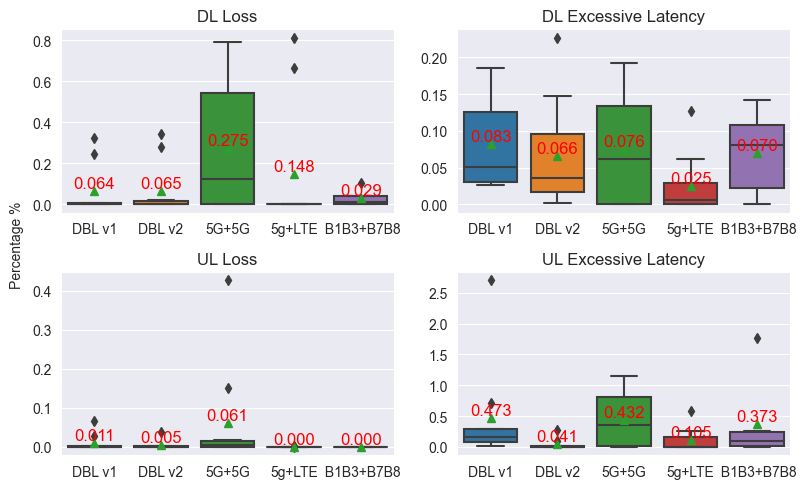

In [24]:
# Box plot of performance.
fig, axes = plt.subplots(2,2, figsize=(8,5))
dl_loss_boxes, dl_excl_boxes = [], []
ul_loss_boxes, ul_excl_boxes = [], []
labels = ['DBL v1', 'DBL v2', '5G+5G', '5g+LTE', ' B1B3+B7B8']

sns.set_style("darkgrid")

for d in [action_group, action_group_v2_1, control_group, control_group2, control_group3]:

    dl_loss_box = [value*100 for value in d['dl_loss'] ] 
    dl_excl_box = [value*100 for value in d['dl_excl'] ] 
    ul_loss_box = [value*100 for value in d['ul_loss'] ]
    ul_excl_box = [value*100 for value in d['ul_excl'] ]

    dl_loss_boxes.append(dl_loss_box)
    dl_excl_boxes.append(dl_excl_box)
    ul_loss_boxes.append(ul_loss_box)
    ul_excl_boxes.append(ul_excl_box)

# A useful one.
def int_to_bin(x):
    x = bin(x)
    if len(x) < 4:
        x = x[:2] + '0' + x[2:]
    return x[2:]

titles = ['DL Loss', 'DL Excessive Latency', 'UL Loss', 'UL Excessive Latency']

for i, target in enumerate([dl_loss_boxes, dl_excl_boxes, ul_loss_boxes, ul_excl_boxes]):

    s = int_to_bin(i)
    n1, n2 = int(s[0]), int(s[1])

    data = {k:v for k, v in zip(labels, target)}
    sns.boxplot(data=list(data.values()), showmeans=True, ax=axes[n1, n2]) 
    axes[n1][n2].set_title(titles[i])
    axes[n1,n2].set_xticks(list(range(len(labels))))
    axes[n1][n2].set_xticklabels(labels, rotation=0)

    # Textx the value of mean.
    for j, group_name in enumerate(data.keys()):
        mean_value = sum(data[group_name])/len(data[group_name])
        axes[n1, n2].text(j, mean_value, f'{mean_value:.3f}', ha='center', va='bottom', fontsize=12, color='red')

# fig.text(0.5, 0.0, 'common xlabel', ha='center', va='center', fontsize=16)
fig.text(0.0, 0.5, 'Percentage %', ha='center', va='center', rotation='vertical')

plt.tight_layout()
plt.show()

In [ ]:
control_group2

In [ ]:
empty_dict = {'dl_loss': [],'dl_excl': [],'ul_loss': [], 'ul_excl': []}
all_comb_metric_dict = {k: copy.deepcopy(empty_dict) for k in comb_metric_dicts[0].keys()}

for d in comb_metric_dicts:
    for device in d:
        for metric in d[device]:
            all_comb_metric_dict[device][metric] += d[device][metric]
            
# all_comb_metric_dict

In [ ]:
# This place calculate the average performance of an 
# experiment setting and plot the heatmap below.
 
num = 0
comb_metric_dict = comb_metric_dicts[num]
settings = EXPs[num].settings

# num_of_devs = 2
num_of_devs = len(settings)
data_dl_loss = np.zeros((num_of_devs, num_of_devs))
data_dl_excl = np.zeros((num_of_devs, num_of_devs))
data_ul_loss = np.zeros((num_of_devs, num_of_devs))
data_ul_excl = np.zeros((num_of_devs, num_of_devs))

keys = list(comb_metric_dict.keys())
count = 0

for i in range(num_of_devs):
    for j in range(i+1, num_of_devs):

        k = keys[count]
        
        dl_loss = np.mean(comb_metric_dict[k]['dl_loss'])
        dl_excl = np.mean(comb_metric_dict[k]['dl_excl'])
        ul_loss = np.mean(comb_metric_dict[k]['ul_loss'])
        ul_excl = np.mean(comb_metric_dict[k]['ul_excl'])

        data_dl_loss[i, j] = dl_loss*100
        data_dl_excl[i, j] = dl_excl*100
        data_ul_loss[i, j] = ul_loss*100
        data_ul_excl[i, j] = ul_excl*100

        count += 1


In [ ]:
fig, axes = plt.subplots(2,2, figsize=(8,6))

labels = list(settings.values())
mask = np.tri(data_dl_loss.shape[0], dtype=bool, k=0)

sns.heatmap(data_dl_loss, ax=axes[0,0], mask=mask, annot=True, fmt=".2f")
axes[0,0].set_xticklabels(labels, rotation=90)
axes[0,0].set_yticklabels(labels, rotation=0)
axes[0,0].set_title('DL Loss')
sns.heatmap(data_dl_excl, ax=axes[0,1], mask=mask, annot=True, fmt=".2f")
axes[0,1].set_xticklabels(labels, rotation=90)
axes[0,1].set_yticklabels(labels, rotation=0)
axes[0,1].set_title('DL Excessive Latency')
sns.heatmap(data_ul_loss, ax=axes[1,0], mask=mask, annot=True, fmt=".2f")
axes[1,0].set_xticklabels(labels, rotation=90)
axes[1,0].set_yticklabels(labels, rotation=0)
axes[1,0].set_title('UL Loss')
sns.heatmap(data_ul_excl, ax=axes[1,1], mask=mask, annot=True, fmt=".2f")
axes[1,1].set_xticklabels(labels, rotation=90)
axes[1,1].set_yticklabels(labels, rotation=0)
axes[1,1].set_title('UL Excessive Latency')

plt.tight_layout()
plt.show()

# HO analysis

In [ ]:
# This place take off the HO closeness of dual radio system.
counts = []
corresponding_list = []

for EXP in EXPs:

    exp_dir_path = EXP.path
    settings = EXP.settings 

    dev_dir_list = find_device_under_exp(exp_dir_path)
    comb = itertools.combinations(dev_dir_list, 2)

    date = exp_dir_path.split('/')[-2]
    name = exp_dir_path.split('/')[-1]
    
    for dev_dir_path1, dev_dir_path2 in comb:
        
        dev1 = dev_dir_path1.split('/')[-1]
        dev2 = dev_dir_path2.split('/')[-1]

        trace_dir_list1 = find_trace_under_device(dev_dir_path1)
        trace_dir_list2 = find_trace_under_device(dev_dir_path2)
        
        for trace_dir_path1, trace_dir_path2 in zip(trace_dir_list1, trace_dir_list2):
            
            # Record
            trace = trace_dir_path1.split('/')[-1]
            print(date, name, dev1, dev2, trace)
            corresponding_list.append((date, name, dev1, dev2, trace))
        
            rrc_file_path1 = os.path.join(trace_dir_path1, 'data')
            rrc_file1 = [os.path.join(rrc_file_path1, s) for s in os.listdir(rrc_file_path1) if s.endswith('_rrc.csv')][0]    
            rrc_file_path2 = os.path.join(trace_dir_path2, 'data')
            rrc_file2 = [os.path.join(rrc_file_path2, s) for s in os.listdir(rrc_file_path2) if s.endswith('_rrc.csv')][0]

            hos1 = parse_mi_ho(rrc_file1)
            hos2 = parse_mi_ho(rrc_file2)

            # Check if there exist too close RLF of two radios.
            events = ['RLF+RLF', 'RLF+Conn Req']
            count = {k:0 for k in events}
            
            for a in (hos1['RLF_II'] + hos1['RLF_III']):
                for b in (hos2['RLF_II'] + hos2['RLF_III']):
                    if abs((a.start - b.start).total_seconds() ) < 2:
                        count['RLF+RLF'] += 1

            for a in (hos1['RLF_II'] + hos1['RLF_III']):
                for b in hos2['Conn_Req']:
                    if abs((a.start - b.start).total_seconds() ) < 2:
                        count['RLF+Conn Req'] += 1

            counts.append(count)

In [ ]:
action_group = {k:0 for k in events}
action_group_v2_1 = {k:0 for k in events}
action_group_v2_2 = {k:0 for k in events}
control_group = {k:0 for k in events} # All + All
control_group2 = {k:0 for k in events} # All + LTE
control_group3 = {k:0 for k in events} # Lock Band+Lock Band

n1,n2,n3,n4 = 0,0,0,0

for d, info in zip(counts, corresponding_list):

    name = info[1]   
    if name == 'Modem_Action_Test':
        n1 += 1
    elif name == 'Control_Group':
        n2 += 1
    elif name == 'Control_Group2':
        n3 += 1
    elif name == 'Control_Group3':
        n4 += 1

    for k, v in d.items():
        if name == 'Modem_Action_Test':
            action_group[k] += v
        elif name == 'Control_Group':
            control_group[k] += v
        elif name == 'Control_Group2':
            control_group2[k] += v
        elif name == 'Control_Group3':
            control_group3[k] += v

action_group, action_group_v2_1, action_group_v2_2, control_group, control_group2, control_group3

In [ ]:
sns.set(style='white')

# 示例数据
categories = ['DBL', '5G+5G', '5G+LTE', 'B1B3+B7B8']
values = [action_group['RLF+RLF']/n1, control_group['RLF+RLF']/n2, control_group2['RLF+RLF']/n3, control_group3['RLF+RLF']/n4]
values2 = [action_group['RLF+Conn Req']/n1, control_group['RLF+Conn Req']/n2, control_group2['RLF+Conn Req']/n3, control_group3['RLF+Conn Req']/n4]


width = 0.3
x = list(range(len(categories)))
x1 = [a-width/2 for a in x]
x2 = [a+width/2 for a in x]

D = {}
for i in range(len(categories)):
    D[categories[i]] = []

# 示例数据
data = []

# 使用for循环生成数据
for i in range(len(categories)):
    name = categories[i]
    value1 = values[i]
    value2 = values2[i]
    data.append({'Scheme': name, 'Average Times': values[i], 'Type': 'RLF+RLF'})
    data.append({'Scheme': name, 'Average Times': values2[i], 'Type': 'RLF+Conn Req'})

# 将数据转换为Pandas DataFrame
df = pd.DataFrame(data)
sns.barplot(x='Scheme', y='Average Times', hue='Type', data=df, palette='rocket')

# plt.title('')  # 图表标题
plt.show()

In [ ]:
rrc_files = []
corresponding_list = []
HOs = []

for EXP in EXPs:

    dev_metric_dict = {}    
    exp_dir_path = EXP.path
    settings = EXP.settings 

    date = exp_dir_path.split('/')[-2]
    name = exp_dir_path.split('/')[-1]

    dev_dir_list = find_device_under_exp(exp_dir_path)

    for dev_dir_path in dev_dir_list:

        dev = dev_dir_path.split('/')[-1]
        trace_dir_list = find_trace_under_device(dev_dir_path)
        
        for trace_dir_path in trace_dir_list:
            
            trace = trace_dir_path.split('/')[-1]
            corresponding_list.append((date, name, dev, trace))
            print(date, name, dev, trace)

            rrc_file_path = os.path.join(trace_dir_path, 'data')
            rrc_file = [os.path.join(rrc_file_path, s) for s in os.listdir(rrc_file_path) if s.endswith('_rrc.csv')][0]
            rrc_files.append(rrc_file)

            hos = parse_mi_ho(rrc_file)
            HOs.append(hos)

In [ ]:
len(corresponding_list), corresponding_list[:10], len(rrc_files), rrc_files[:10]

In [ ]:
# Count HO durations
counted_events = ['Conn_Req', 'LTE_HO', 'MN_HO', 'MN_HO_to_eNB', 'RLF_II', 'RLF_III',
                  'SCG_RLF', 'SN_HO', 'SN_Rel', 'SN_setup']
data = {k: [] for k in counted_events}

for info, hos in zip(corresponding_list, HOs):
    name, dev = info[1], info[2]

    for k in counted_events:
        for ho in hos[k]:
            try:
                dif = (ho.end-ho.start).total_seconds()
                data[k].append(dif)
            except: pass


In [ ]:
labels = list(data.keys())
labels = [s.replace('_', ' ') for s in labels]
labels[0] = 'Re-Conn'
values = list(data.values())

plt.figure(figsize=(10.5, 3))
plt.boxplot(values, labels=labels, patch_artist=True, boxprops=dict(facecolor='lightblue', color='blue'), showmeans=True, meanprops=dict(markerfacecolor='red', marker='D'))

plt.ylim([0,0.5])

plt.title('HO Duration')
plt.xlabel('HO Type')
plt.ylabel('Second')

plt.show()
